In [1]:
!pip install bitsandbytes transformers accelerate peft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 60.4 MB/s eta 0:00:00


In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
from transformers import AutoTokenizer, PaliGemmaForConditionalGeneration, PaliGemmaProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "google/paligemma-3b-mix-224"
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16)
processor = PaliGemmaProcessor.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

In [47]:
from PIL import Image, ImageDraw, ImageFont

input_image = Image.open('/content/car.jpeg')

# Create a copy of the input image.
output_img = input_image
input_text = "detect car"

In [48]:
inputs = processor(text=input_text, images=input_image,
                  padding="longest", do_convert_rgb=True, return_tensors="pt").to("cuda")
model.to(device)
inputs = inputs.to(dtype=model.dtype)

In [49]:
with torch.no_grad():
  output = model.generate(**inputs, max_length=496)

paligemma_response = processor.decode(output[0], skip_special_tokens=True)[len(input_text):].lstrip("\n")
print(paligemma_response)

detections = paligemma_response.split(" ; ")

<loc0257><loc0295><loc0752><loc0721> car


In [50]:
parsed_coordinates = []
labels = []

for item in detections:
    # Remove '<loc>' tags and split the string
    coordinates_str, label = item.replace("<loc", "").split()
    labels.append(label)
    # Split the coordinates string by '><' to get individual coordinates
    coordinates = coordinates_str.split(">")

    if coordinates[-1] == '':
      coordinates = coordinates[:-1]

    coordinates = [int(coord)/1024 for coord in coordinates]
    parsed_coordinates.append(coordinates)

In [51]:
print(parsed_coordinates)
print(labels)

[[0.2509765625, 0.2880859375, 0.734375, 0.7041015625]]
['car']


In [52]:
width = input_image.size[0]
height = input_image.size[1]
print(width)
print(height)

output_image = ImageDraw.Draw(output_img)

750
450


In [53]:
def draw_bounding_box(draw, coordinates, label):
    y1, x1, y2, x2 = coordinates
    y1, x1, y2, x2 = map(round, (y1*height, x1*width, y2*height, x2*width))


    text_width, text_height = draw.textsize(label)
    draw.rectangle([(x1, y1 - text_height - 2), (x1 + text_width + 4, y1)], fill="red")

    # Draw label text
    draw.text((x1 + 2, y1 - text_height - 2), label, fill="white")

    # Draw bounding box
    draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=2)

for coordinates, label in zip(parsed_coordinates, labels):
  draw_bounding_box(output_image, coordinates, label)

<ipython-input-53-8f1c9533d629>:6: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(label)


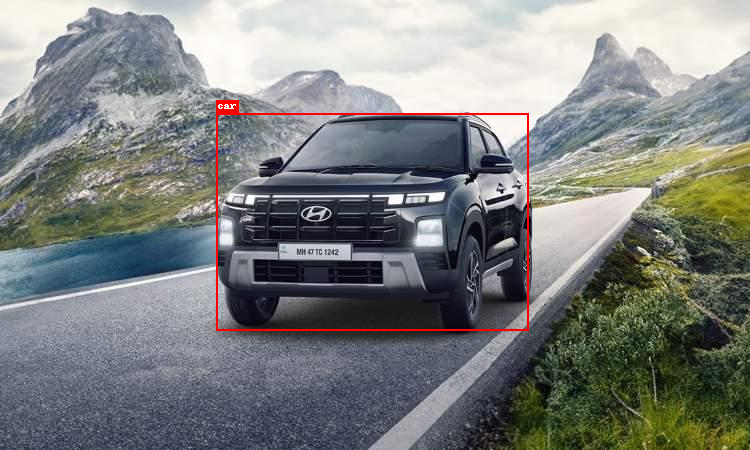

In [54]:
output_img